In [ ]:
!pip install imageio
!pip install imageio-ffmpeg
!pip install jiwer

In [ ]:
import collections
from datetime import datetime
import itertools
import logging
import multiprocessing
import os
import random
import string

from jiwer import wer, mer
import imageio
import keras
from keras import layers, models, optimizers
from keras.applications import VGG16
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image
from PIL import ImageFilter
from scipy import ndimage, signal
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf

# Parallel processing code requires us to have this line here. Otherwise there
# will be contention between multiple processes trying to use the same GPU.
tf.config.set_visible_devices([], 'GPU')
tf.get_logger().setLevel(logging.ERROR)

# The Problem

The problem is described in detail [here](https://www.aicrowd.com/challenges/ai-blitz-6/problems/chess-transcription). Given a video file of a part of a chess game being played, the moves made in the video file are to be provided as a string output based on the Cartesian Coordinate System

# Non-ML Solution

### Helper Functions


These functions have been explained in detail in the previous Chess problems:

1. [Chess Pieces](https://github.com/keyapandia123/aicrowd/blob/main/chess/chess_pieces.ipynb)
2. [Chess Points](https://github.com/keyapandia123/aicrowd/blob/main/chess/chess_points.ipynb)
3. [Chess Configuration](https://github.com/keyapandia123/aicrowd/blob/main/chess/chess_config.ipynb)

In [ ]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

In [ ]:
def return_templates(to_print=False):
    """
    Return templates for black and white pieces.

    Use image 0 of problem 3 (chess configuration) to select 
    two black pieces (pawns) and two white pieces (pawns) for template-matching. 
    This is the first stage of template-matching 
    to determine whether or not a piece is present in a given block.
    """
    what='template'
    image_id=0
    img_template = PIL.Image.open(os.path.join(os.getcwd(), what, f'{image_id}.jpg'))
    img_template = img_template.resize((256, 256))
    img_np = np.array(img_template)
    imgbw_template = img_template.convert(mode='L')
    imgbw_np_template = np.array(imgbw_template)
    
    template_b1 = blockshaped(imgbw_np_template, 32, 32)[8]
    template_b2 = blockshaped(imgbw_np_template, 32, 32)[15]
    template_w1 = blockshaped(imgbw_np_template, 32, 32)[25]
    template_w2 = blockshaped(imgbw_np_template, 32, 32)[35]
    
    if to_print:
        plt.imshow(imgbw_np_template)
        
        fig = plt.figure()
        plt.subplot(2,2,1)
        plt.imshow(template_b1)
        plt.subplot(2,2,2)
        plt.imshow(template_b2)
        plt.subplot(2,2,3)
        plt.imshow(template_w1)
        plt.subplot(2,2,4)
        plt.imshow(template_w2)
            
            
    return template_b1, template_b2, template_w1, template_w2

In [ ]:
def norm_corr(block, template):
    """
    Perform normalized 2D correlation.

    Subtract block mean from block and template mean from template before 
    correlating. Divide correlation output by block standard deviation and 
    template standard deviation.
    """
    
    return signal.correlate2d(block - np.mean(block), template - np.mean(template)) / (np.std(block) * np.std(template))

In [ ]:
#Thresholds to go with first quantization step
BLACK_TH1 = 10
WHITE_TH1 = 246

def quantize(imgbw_np):
    """
    Quantize the image into three values for black, white, and background.

    Setting three discrete values for each image pixel. One value for each 
    piece color and the third for the background.
    """
    new_img = imgbw_np.copy()

    new_img[imgbw_np < BLACK_TH1] = 0
    new_img[imgbw_np > WHITE_TH1] = 255
    new_img[(imgbw_np >= BLACK_TH1) & (imgbw_np <= WHITE_TH1)] = 128
    
    return new_img

In [ ]:
#Thresholds to go with second quantization step
BLACK_TH2 = 115
WHITE_TH2 = 135
    

def blur_and_quantize(imgbw_np, img=None, img_np=None):
    """
    Blur quantized image and then quantize the blurred image again.
    Different pixel intensity thresholds are used for the first and second quantization steps. 
    """
    
    new_img1 = imgbw_np.copy()
    new_img = quantize(imgbw_np)
    
    img = Image.fromarray(new_img)
    
    # use blurring
    img_blurred = img.filter(ImageFilter.GaussianBlur(radius=2))
    imgbw_np = np.array(img_blurred)
    
    new_img[imgbw_np < BLACK_TH2 ] = 0
    new_img[imgbw_np > WHITE_TH2] = 255
    new_img[(imgbw_np >= BLACK_TH2) & (imgbw_np <= WHITE_TH2)] = 128
    
    return new_img

In [ ]:
def templates(to_print=False):
    """
    From training image 0 of problem 3, select blocks having pieces 
    corresponding to each piece type for each color (B and W)
    Piece types for each color are king, pawn, knight, bishop, rook, and queen
    Return these selected blocks as second and third sets of templates.
    This is the second stage of template-matching to determine the type of piece present in a block.
    
    """
    what='template'
    image_id=0
    train_img = PIL.Image.open(os.path.join(os.getcwd(), what, f'{image_id}.jpg'))
    train_img = train_img.resize((256, 256))
    img_np = np.array(train_img)
    
    imgbw = train_img.convert(mode='L')
    imgbw_np = np.array(imgbw)
    
    img_block = blockshaped(imgbw_np, 32, 32)
    
    black_templates = []
    black_string = ['k', 'p', 'n', 'b', 'r', 'q']
    black_points = [0, 1, 3, 3, 5, 9]
    white_templates = []
    white_string = ['K', 'P', 'N', 'B', 'R', 'Q']
    white_points = [0, 1, 3, 3, 5, 9]
    
    black_templates.append(img_block[4]) #King
    black_templates.append(img_block[15]) #Pawn
    black_templates.append(img_block[12]) #Knight
    black_templates.append(img_block[2]) #Bishop
    black_templates.append(img_block[1]) #Rook
    black_templates.append(img_block[3]) #Queen
    
    white_templates.append(img_block[60]) #King
    white_templates.append(img_block[48]) #Pawn
    white_templates.append(img_block[40]) #Knight
    white_templates.append(img_block[61]) #Bishop
    white_templates.append(img_block[56]) #Rook
    white_templates.append(img_block[59]) #Queen
    
    if to_print: 
        fig = plt.figure()
        for i in range(1, 7):
            plt.subplot(1, 6, i)
            plt.imshow(black_templates[i-1])
            plt.xlabel(black_string[i-1])
        
        fig = plt.figure()
        for i in range(1, 7):
            plt.subplot(1, 6, i)
            plt.imshow(white_templates[i-1])
            plt.xlabel(white_string[i-1])
    
    return black_templates, black_string, white_templates, white_string

In [ ]:
BL_CORR_TH = 200
WH_CORR_TH = 150

WHITE_TH3 = 9
BLACK_TH3 = 15

def vector_black_white_background_pieces(imgbw_np, new_img, center_only=False):
    """
    Classify each block as B piece, W piece, or background
    """
    no_of_blocks = 64
    w = 5
    h = w + 4
    
    x = []
    y = []
    
    template_b1, template_b2, template_w1, template_w2 = return_templates(to_print=False)
    for i in range(no_of_blocks):
        img_block_raw = blockshaped(imgbw_np, 32, 32)[i]
        img_block_quantized = blockshaped(new_img, 32, 32)[i]
        
        # First, detect via correlation (template-matching) whether there is a piece or not in a given block
        out1 = norm_corr(img_block_raw, template_b1)
        out2 = norm_corr(img_block_raw, template_b2)
        out3 = norm_corr(img_block_raw, template_w1)
        out4 = norm_corr(img_block_raw, template_w2)
        
        if np.max(out1.flatten()) < BL_CORR_TH and np.max(out2.flatten()) < BL_CORR_TH and np.max(out3.flatten()) < WH_CORR_TH and np.max(out4.flatten()) < WH_CORR_TH:
            y.append(0.0)  # Background block correlated with none of the four templates will meet the specified threshold
        
        # Second, if piece is present, detect using majority counting hueristic whether the piece is black or white
        else:
            if center_only:
                center = img_block_quantized[16-h:16+h, 16-w:16+w]
                block_dict = collections.Counter(center.flatten())
            else:
                block_dict = collections.Counter(img_block_quantized.flatten())
            
            
            if block_dict[255.0] > WHITE_TH3 or block_dict[255.0] > block_dict[0.0]: 
                y.append(1.0)
                
            elif block_dict[0.0] > BLACK_TH3 and block_dict[0.0] > block_dict[255.0]: 
                y.append(-1.0)
                
            else:
                y.append(0.0)
                
      
    x = np.array(x)
    x = np.expand_dims(x, -1)
    y = np.array(y)
    return x, y

### Step 1: Given a video ID, generate an image stack of consecutive frames from the video

In [ ]:
def show_video(video_id=None, what='train'):
    """Show a random or requested video."""
    if video_id is None:
        all_files = os.listdir(what)
        vid_file = random.sample(all_files, 1)[0]
        video_id, _ = os.path.splitext(vid_file)
    
    label_df = pd.read_csv(f'{what}.csv')
    vid = imageio.get_reader(f'{what}/{video_id}.mp4', 'ffmpeg')
    label = label_df[label_df['VideoID'] == int(video_id)].iloc[0, 1]
    num_frames = len([x for x in vid])
    img_stack = np.array([x for x in vid])
    
    return vid, label, video_id, num_frames, img_stack 

No of frames =  18


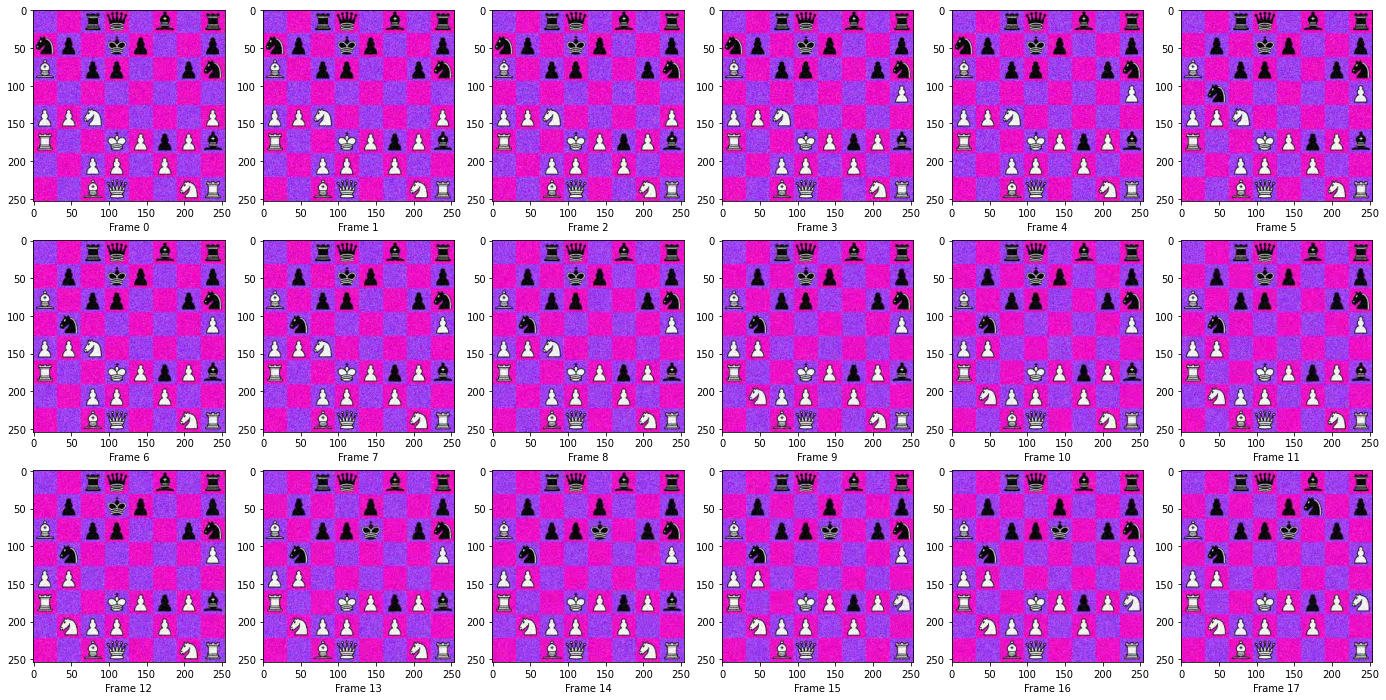

In [ ]:
vid, label, video_id, num_frames, img_stack = show_video(video_id=3)

print("No of frames = ", num_frames)
fig = plt.figure(figsize=(24, 12))
for i in range(num_frames):
    plt.subplot(3, 6, i+1)
    plt.imshow(img_stack[i])
    plt.xlabel(f'Frame {i}')

### Step 2: Generate configuration string for each frame based on the Forsyth–Edwards Notation ([FEN](https://www.chess.com/terms/fen-chess)) convention

For each frame of the video (i.e., for each image of the image stack), generate the board configuration string as described in the [non-ML solution (template-matching)](https://github.com/keyapandia123/ds/blob/main/chess/chess_config.ipynb) to [problem 3 (chess configuration)](https://www.aicrowd.com/challenges/ai-blitz-6/problems/chess-configuration):
* Determine whether or not a piece is present on a block
* Determine whether a detected piece is black or white
* Determine the type of piece, given the piece color, each piece type having a predefined label for black pieces ('k', 'p', 'n', 'b', 'r', 'q') and for white pieces ('K', 'P', 'N', 'B', 'R', 'Q')
* Generate the board configuration string by concatenating the predicted labels for each piece (indicating color and piece type), counting the number of contiguous background blocks in a given row, and representing the end of each row of blocks (except the last row) with a '/'

In [ ]:
def generate_string(imgbw_np, to_plot=False):
    """
    Generate configuration string given an input image.
    
    Given a numpy array for a grayscale image, generate a configuration string 
    as output for the chess board in the image. Generate a vector of 64 
    elements indicating whether a block is background or contains a black piece 
    or a white piece. Identify the type of piece (k, p, n, b, r, or q) for the 
    identified color. Append appropriate label to the configuration string 
    (continuous background squares are indicated by a number).
    """
    
    new_img1 = blur_and_quantize(imgbw_np)
    if to_plot:
        plt.imshow(imgbw_np)
        fig = plt.figure()
        plt.imshow(new_img1)
    
    new_img2 = quantize(imgbw_np)
    
    img_block = blockshaped(imgbw_np, 32, 32)
      
    _, y = vector_black_white_background_pieces(imgbw_np, new_img1, center_only=True)

    string = []
    black_templates, black_string, white_templates, white_string = templates()
    bg_cnt = 0
    for block in range(64):
        if y[block] == 0.0:  # background block
            bg_cnt += 1
            if ((block < 63) and (y[block + 1] != 0.0)) or (not (block + 1) % 8):
                string.append(str(bg_cnt))
                bg_cnt = 0
            
        scores = []
        if y[block] != 0:  # not background block
            test_block = np.squeeze(img_block[block, :, :])
            
            for i in range(1, 7):
                bt = black_templates[i-1] - np.mean(black_templates[i-1].flatten())
                wt = white_templates[i-1] - np.mean(white_templates[i-1].flatten())
                if y[block] == -1.0:  # if black piece, correlate with black templates
                    cor = norm_corr(test_block, bt)
                    
                elif y[block] == +1.0:  # if white piece, correlate with white templates
                    cor = norm_corr(test_block, wt)
                    
                scores.append(np.max(cor.flatten()))

        
            if y[block] == -1.0:
                string.append(black_string[np.argmax(np.array(scores))])
            elif y[block] == +1.0:
                string.append(white_string[np.argmax(np.array(scores))])
        
        if block < 63 and not (block + 1) % 8:
            string.append('/')
            bg_cnt = 0
                 
    return ''.join(string)

In [ ]:
def return_board_configurations_for_all_frames(video_id=None, what='train'):
   """Generate a list of configuration strings for all frames in a video."""
    vid, label, video_id, num_frames, img_stack = show_video(video_id, what)
       
    configurations_for_all_frames = []

    for idx in range(num_frames):
        img = PIL.Image.fromarray(img_stack[idx])
        imgbw = img.convert('L')
        imgbw = imgbw.resize((256, 256))
        imgbw_np = np.array(imgbw)

        config = generate_string(imgbw_np, to_plot=False)
        configurations_for_all_frames.append(config)
    return label, configurations_for_all_frames

Consider, for example, Frames 4 and 5 where the black knight is moved from the seventh row first column (a7) to the fifth row second column (b5).  The corresponding frames and board configuration strings are shown below.

Configuration String:  2rq1b1r/np1kp2p/B1pp2pn/7P/PPN5/R2KPpPb/2PP1P2/2BQ2NR


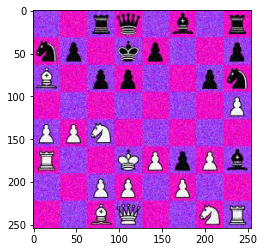

In [ ]:
# Frame 4
img4 = PIL.Image.fromarray(img_stack[4])
imgbw4 = img4.convert('L')
imgbw4 = imgbw4.resize((256, 256))
imgbw_np4 = np.array(imgbw4)

config4 = generate_string(imgbw_np4, to_plot=False)
plt.imshow(img4)
print("Configuration String: ", config4)

Configuration String:  2rq1b1r/1p1kp2p/B1pp2pn/1n5P/PPN5/R2KPpPb/2PP1P2/2BQ2NR


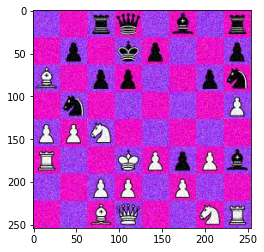

In [ ]:
# Frame 5
img5 = PIL.Image.fromarray(img_stack[5])
imgbw5 = img5.convert('L')
imgbw5 = imgbw5.resize((256, 256))
imgbw_np5 = np.array(imgbw5)

config5 = generate_string(imgbw_np5, to_plot=False)
plt.imshow(img5)
print("Configuration String: ", config5)

### Step 3: Expand the configuration string into a 64 character string for each frame

Each empty (background) block is represented by a '*' and each end of row '/' is dropped.  The labels for the pieces remain unchanged.  

In [ ]:
def _expand(string):
    """Expand a config string with * for spaces to be exactly of length 64."""
    adj = []
    for c in string:
        if c == '/':
            continue
        if c.isdigit():
            adj = adj + ['*'] * int(c)
        else:
            adj.append(c)
    return ''.join(adj)

In [ ]:
print("Expanded configuration string for Frame 4: ", _expand(config4))
print("Expanded configuration string for Frame 5: ", _expand(config5))

Expanded configuration string for Frame 4:  **rq*b*rnp*kp**pB*pp**pn*******PPPN*****R**KPpPb**PP*P****BQ**NR
Expanded configuration string for Frame 5:  **rq*b*r*p*kp**pB*pp**pn*n*****PPPN*****R**KPpPb**PP*P****BQ**NR


### Step 4: Detect moves between consecutive frames 

For each pair of consecutive frames (images):

* Detect whether a move has occurred (if the two frames have identical configuration strings, no move occurred between those two frames).  For example, Frame 0 and Frame 1 of the above video file have identical configuration strings and therefore no move was detected between Frames 0 and 1. 
* If the configuration strings of two consecutive frames A and B are not identical (i.e., if a move is detected between A and B, as shown above for Frames 4 and 5), determine:
1. the piece that was moved (the piece is present on a given block of frame A, but no piece is present in that same block of frame B),
2. the coordinates (row number and column letter, per Cartesian coordinates) of the block from which the piece was moved
3. the coordinates (row number and column letter, per Cartesian coordinates) of the block to which the piece was moved, by identifying which block has the moved piece in frame B but not in fram A

Provide a list of all moves detected between all pairs of consecutive frames in the video

In [ ]:
def predict_moves(video_id=None, what='train', to_print=False):
    """Provides a list of all moves detected within a video file."""
    moves = []
    
    label, configurations_for_all_frames = return_board_configurations_for_all_frames(video_id, what)

    for pos, config in enumerate(configurations_for_all_frames[:-1]):
        next_config = configurations_for_all_frames[pos+1]
        if config == next_config:  # no move occurred between config and next_config
            continue
        else:
            config_adj = _expand(config)
            next_config_adj = _expand(next_config)
            piece_moved = None
            new_piece = None
            to_col = None
            from_row = None
            
            if (config_adj[4:8] == 'k**r') and (next_config_adj[4:8] == '*rk*'): # black king side castling
                moves.append('e8g8')
                continue
            
            if ('r***k' in config_adj[0:5]) and (next_config_adj[0:5] == '**kr*'): # black queen side castling
                moves.append('e8c8')
                continue
                
            if (config_adj[60:64] == 'K**R') and (next_config_adj[60:64] == '*RK*'): # white king side castling
                moves.append('e1g1')
                continue
            
            if (config_adj[56:61] == 'R***K') and (next_config_adj[56:61] == '**KR*'): # white queen side castling
                moves.append('e1c1')
                continue
                

            for pos, (ch1, ch2) in enumerate(zip(config_adj, next_config_adj)):  # detecting which piece moved and from where
                if ch1.isalpha() and ch2 == '*':
                    piece_moved = ch1
                    from_pos = pos
                    from_row = str(8 - pos // 8)
                    from_col = string.ascii_lowercase[pos % 8]
                    
            if piece_moved and (piece_moved == 'p' or piece_moved == 'P'): # detecting a passed pawn
                for pos, (ch1, ch2) in enumerate(zip(config_adj, next_config_adj)):
                    if (pos // 8 == 0 or pos // 8 == 7) and ch2 != ch1:
                        new_piece = ch2
                        to_pos = pos
                        to_row = str(8 - pos // 8)
                        to_col = string.ascii_lowercase[pos % 8]
                if new_piece:
                    move = ''.join([from_col, from_row, to_col, to_row, new_piece])          
                    moves.append(move)
                    continue
            
            if piece_moved and not new_piece:  # ordinary move (not a passed pawn)
                for pos, (ch1, ch2) in enumerate(zip(config_adj, next_config_adj)):
                    if ch1 != piece_moved and ch2 == piece_moved:
                        to_pos = pos
                        to_row = str(8 - pos // 8)
                        to_col = string.ascii_lowercase[pos % 8]
                if to_col:
                    move = ''.join([from_col, from_row, to_col, to_row])          
                    moves.append(move)
                    continue
                    
                    
            if from_row and (from_row == '5' or from_row == '4') and not to_col:  # detecting en passant
                for pos, (ch1, ch2) in enumerate(zip(config_adj, next_config_adj)):  
                    if ch1.isalpha() and ch2 == '*':
                        piece_moved = ch1
                        from_pos = pos
                        from_row = str(8 - pos // 8)
                        from_col = string.ascii_lowercase[pos % 8]
                        break
                if piece_moved == 'p' or piece_moved == 'P':
                    for pos, (ch1, ch2) in enumerate(zip(config_adj, next_config_adj)):
                        if ch1 == '*' and ch2 == piece_moved:
                            to_pos = pos
                            to_row = str(8 - pos // 8)
                            to_col = string.ascii_lowercase[pos % 8]
                    if to_col:
                        move = ''.join([from_col, from_row, to_col, to_row])          
                        moves.append(move)
                    
    if to_print: 
        print('Pred moves: ', ' '.join(moves))
        print('True moves: ', label)
        
    return label, ' '.join(moves)

In [ ]:
true, pred = predict_moves(video_id=3, to_print=True)

Pred moves:  h4h5 a7b5 c4b2 d7e6 g1h3 h6f7
True moves:  h4h5 a7b5 c4b2 d7e6 g1h3 h6f7


For the video file above, the first move in the video occurs between Frames 2 and 3, where the white pawn moves from the fourth row eighth column (h4) to the fifth row eighth column (h5), which is the first move listed in the predicted sequence of moves.  

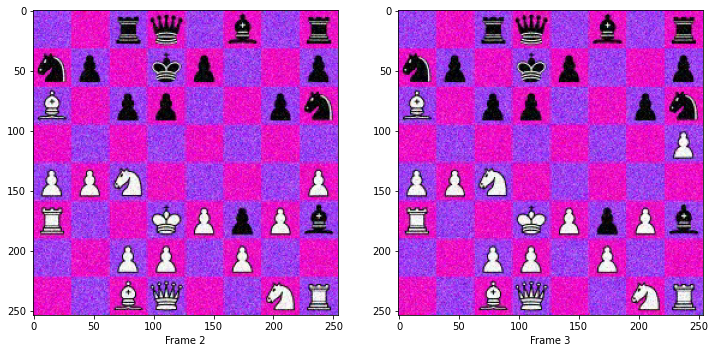

In [ ]:
img2 = PIL.Image.fromarray(img_stack[2])
img3 = PIL.Image.fromarray(img_stack[3])

fig = plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(img2)
plt.xlabel('Frame 2')
plt.subplot(122)
plt.imshow(img3)
_ = plt.xlabel('Frame 3')

As illustrated for the video file above, the second move in the video occurs between Frames 4 and 5, where the black knight moves from the seventh row first column (a7) to the fifth row second column (b5), which is the second move listed in the predicted sequence of moves.

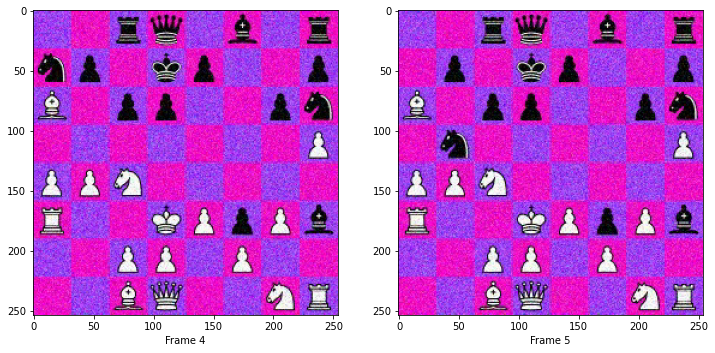

In [ ]:
fig = plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(img4)
plt.xlabel('Frame 4')
plt.subplot(122)
plt.imshow(img5)
_ = plt.xlabel('Frame 5')

### Special case: detecting a promoted pawn¶

If the moved piece is a white or black pawn, check if a new piece is detected on a block in the second frame (frame B) that was either empty or had a different piece than the new piece in the first frame (frame A) and if this block lies in the first or eighth row.  If so, this is a promoted pawn scenario and the from and to blocks need to be further updated with an identifier for the new piece. An example is move 7 below, between frames 22 and 23, where the pawn after advancement from c2 to c1 gets replaced with a black queen (q).  

In [ ]:
true, pred = predict_moves(video_id=939, what='val', to_print=True)

Pred moves:  a7a6 c4d2 e3c4 f5f8 g8h7 a2b2 c2c1q e1e2 h6f4
True moves:  a7a6 c4d2 e3c4 f5f8 g8h7 a2b2 c2c1q e1e2 h6f4


No of frames =  31


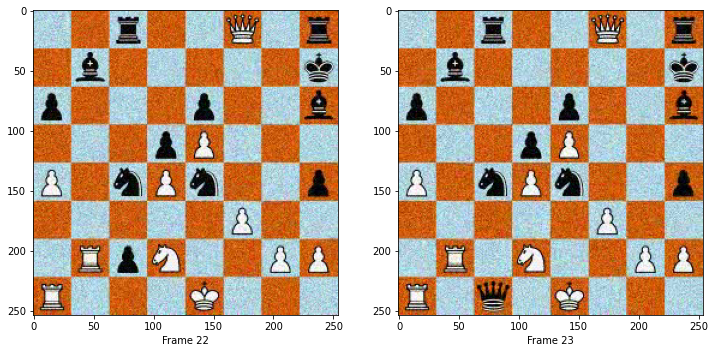

In [ ]:
vid, label, video_id, num_frames, img_stack = show_video(video_id=939, what='val')

print("No of frames = ", num_frames)
fig = plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(img_stack[22])
plt.xlabel('Frame 22')
plt.subplot(122)
plt.imshow(img_stack[23])
_ = plt.xlabel('Frame 23')

### Special case: detecting castling

Referring to Frames 5 and 6 below, move 2 (e8g8) is a special move called castling.  In this example, the black side castles on the king side.    

In [ ]:
true, pred = predict_moves(video_id=2515, what='train', to_print=True)

Pred moves:  b3e3 e8g8 g1e1 a6c7 e3e4 d4e3 e4f4 c7b5 b6b7
True moves:  b3e3 e8g8 g1e1 a6c7 e3e4 d4e3 e4f4 c7b5 b6b7


No of frames =  32


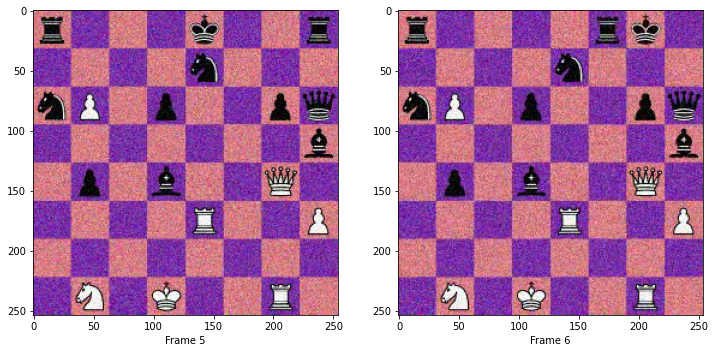

In [ ]:
vid, label, video_id, num_frames, img_stack = show_video(video_id=2515, what='train')

print("No of frames = ", num_frames)
fig = plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(img_stack[5])
plt.xlabel('Frame 5')
plt.subplot(122)
plt.imshow(img_stack[6])
_ = plt.xlabel('Frame 6')


### Special case: detecting en passant 

As seen in move 8 (f5g6) between frames 23 and 24 below, a white pawn on the fifth row or black pawn on the fourth row can capture a piece adjacent to it in the same row if the diagonal block ahead of the piece to be captured is vacant.

In [ ]:
true, pred = predict_moves(video_id=975, what='train', to_print=True)

Pred moves:  g2f2 e3f2 c5a4 b2b3 a8a6 h2h3 g7g5 f5g6 f7e8
True moves:  g2f2 e3f2 c5a4 b2b3 a8a6 h2h3 g7g5 f5g6 f7e8


No of frames =  28


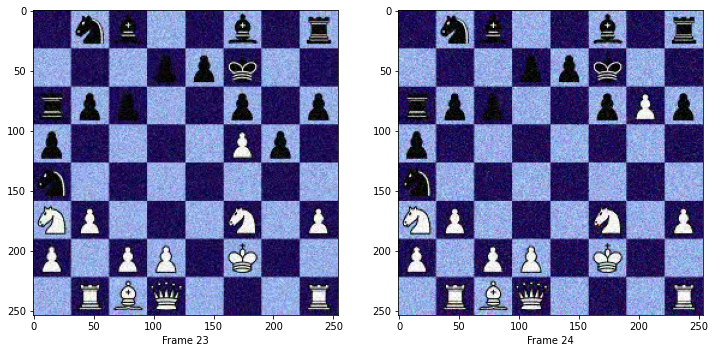

In [ ]:
vid, label, video_id, num_frames, img_stack = show_video(video_id=975)

print("No of frames = ", num_frames)
fig = plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(img_stack[23])
plt.xlabel('Frame 23')
plt.subplot(122)
plt.imshow(img_stack[24])
_ = plt.xlabel('Frame 24')

### Step 5: Repeat across multiple files and generate average accuracy of detected moves across multiple files

In [ ]:
def _parallel_fun(items):
    tf.config.set_visible_devices([], 'GPU')
    return predict_moves(*items)


def avg_accuracy_for_folder(what='train'):
    """
    Compare true and predicted moves over multiple video files.
    Generate average accuracy score across video files.
    """
    all_files = [x for x in os.listdir(what) if x.endswith('.mp4')]
    subset = random.sample(all_files, 20)
    fn_inps = []
    video_ids = []

    for file in subset:
        video_id, _ = os.path.splitext(file)
        video_id = int(video_id)
        video_ids.append(video_id)
        fn_inps.append((video_id, what))
    
    # Using parallel processing to speed up computation. 
    pool = multiprocessing.Pool(multiprocessing.cpu_count())
    results = pool.map_async(_parallel_fun, fn_inps)
    pool.close()
    pool.join()
    x1 = results.get()
    
    score = []
    mislabeled = []
    for video_id, (true, predicted) in zip(video_ids, x1):
        error = wer(true, predicted)
        score.append(error)
        if true != predicted:
            mislabeled.append(video_id)
              
    return np.mean(score), mislabeled

In [ ]:
wer_based, mismatch = avg_accuracy_for_folder(what='train')
print('WER based score (lower the better) = ', wer_based)
print('Mismatched Files: ', mismatch)

WER based score (lower the better) =  0.005555555555555555
Mismatched Files:  [2336]


The approach above misses a move (c8c7) in train file 2336

In [ ]:
true, pred = predict_moves(video_id=2336, what='train', to_print=True)

Pred moves:  d8c8 f1g1 a4b3 d2b3 h8f8 c4c5 e4g2 f5h7
True moves:  d8c8 f1g1 a4b3 d2b3 h8f8 c4c5 c8c7 e4g2 f5h7


### An example of a mismatched file where the approach above misses a move 

White queen move e5e2 (true move 2), between Frames 4 and 5 gets missed.  

In [ ]:
true, pred = predict_moves(video_id=822, what='val', to_print=True)

Pred moves:  g7f8 e6d5 c1b2 g3e2 g1f2 d5c6
True moves:  g7f8 e5e2 e6d5 c1b2 g3e2 g1f2 d5c6


No of frames =  20


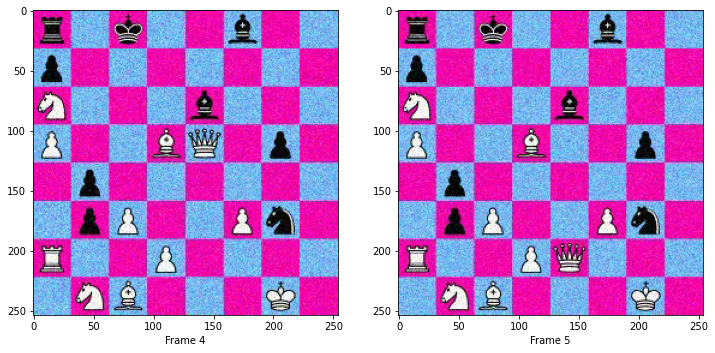

In [ ]:
vid, label, video_id, num_frames, img_stack = show_video(video_id=822, what='val')

print("No of frames = ", num_frames)
fig = plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(img_stack[4])
plt.xlabel('Frame 4')
plt.subplot(122)
plt.imshow(img_stack[5])
_ = plt.xlabel('Frame 5')

### An example of a file for which the above approach fails to generate multiple moves in the correct set/sequence of moves

In [ ]:
true, pred = predict_moves(video_id=2794, to_print=True)

Pred moves:  f4f2 f2c3 c3f4 f8e3 e3g5 f4b8 d6e4 f2e1 b8a5 e1e1*
True moves:  g4h6 d7h3 d6e4 h3c8 g3g2


No of frames =  15


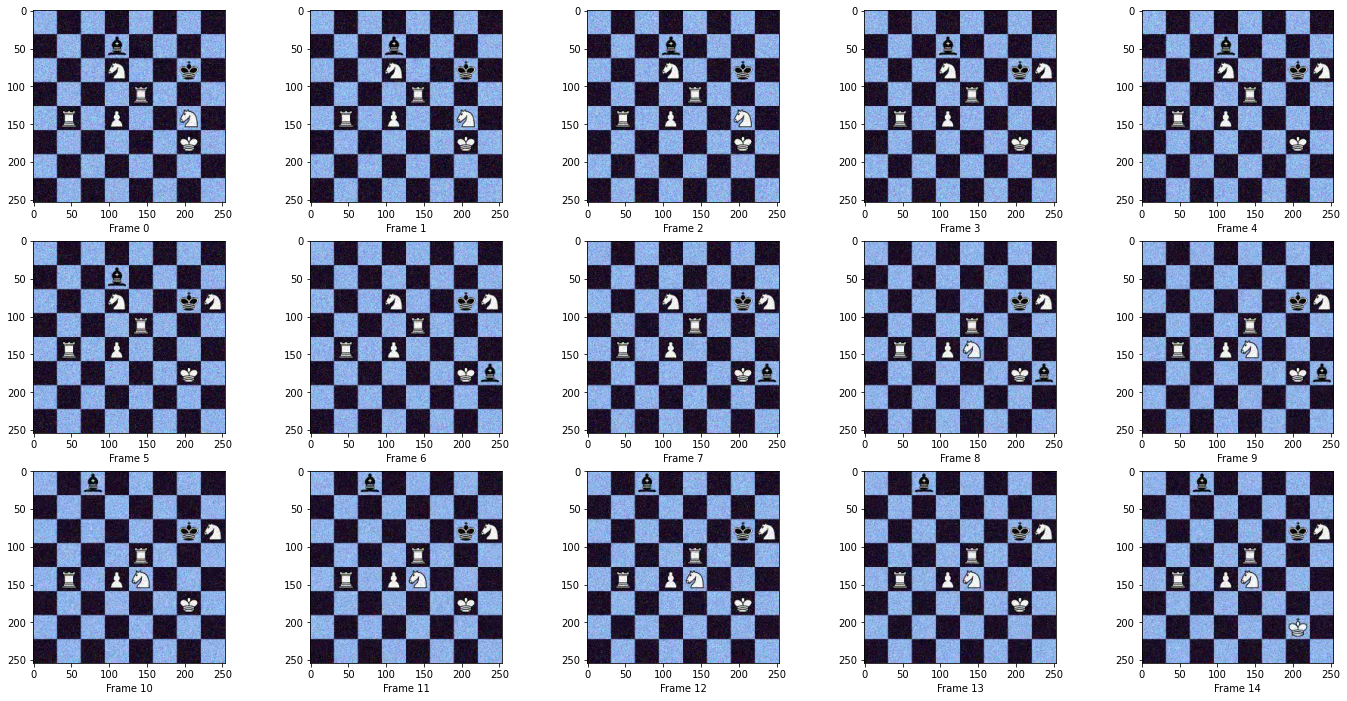

In [ ]:
vid, label, video_id, num_frames, img_stack = show_video(video_id=2794)

print("No of frames = ", num_frames)
fig = plt.figure(figsize=(24, 12))
for i in range(num_frames):
    plt.subplot(3, 5, i+1)
    plt.imshow(img_stack[i])
    plt.xlabel(f'Frame {i}')

# Using Neural Networks (ML)

The only difference between the non-ML and ML approaches is the function that generates the configuration string for the board in an individual frame. The algorithm for determining moves between adjacent frames is the same for both approaches. 

See the non-ML solution above for detailed explanations for all the special cases discussed below.

### Step 1: Use pretrained ML model from ML solution to problem 3 (chess configuration) to generate configuration string for each frame

In [ ]:
dd = {0:'*', # for background
         1: 'k',
         2: 'p',
         3: 'n',
         4: 'b',
         5: 'r',
         6: 'q',
         7: 'K',
         8: 'P',
         9: 'N',
         10: 'B',
         11: 'R',
         12: 'Q'}

def generate_string2(imgbw_np):
    """
    Given a random or specified image, prodvide the predicted configuration string.
    Run the ML model on the given image, convert the one-hot encoded output into a 
    list of ASCII characters specified as values of the dictionary above. 
    Convert the list of ASCII characters into a predicted configuration string.
    """

    img_block = blockshaped(imgbw_np, 32, 32)
    img_block = np.expand_dims(img_block, -1)
    x = img_block / 255.

    model = keras.models.load_model('my_model_chess_config.h5')

    y_pred_one_hot = model.predict(x)
    y_pred = np.argmax(y_pred_one_hot, axis=1)
    y_pred_ascii = [dd[x] for x in y_pred]
    
    
    string = []
    bg_cnt = 0
    for block in range(64):
        if y_pred_ascii[block] == '*':  # background block
            bg_cnt += 1
            if ((block < 63) and (y_pred_ascii[block + 1] != '*')) or (not (block + 1) % 8):
                string.append(str(bg_cnt))
                bg_cnt = 0    
        
        if y_pred_ascii[block] != '*':  # not background block
            string.append(y_pred_ascii[block])
        
        if block < 63 and not (block + 1) % 8:
            string.append('/')
            bg_cnt = 0
                 
    return ''.join(string)

In [ ]:
def return_board_configurations_for_all_frames2(video_id=None, what='train'):
    vid, label, video_id, num_frames, img_stack = show_video(video_id, what)
       
    configurations_for_all_frames = []

    for idx in range(num_frames):
        img = PIL.Image.fromarray(img_stack[idx])
        imgbw = img.convert('L')
        imgbw = imgbw.resize((256, 256))
        imgbw_np = np.array(imgbw)

        config = generate_string2(imgbw_np)
        configurations_for_all_frames.append(config)
    return label, configurations_for_all_frames

### Step 2: Predict sequence of moves by comparing configuration strings between consecutive frames

Similar to the non-ML approach above

In [ ]:
def predict_moves2(video_id=None, what='train', to_print=False):

    moves = []
    
    label, configurations_for_all_frames = return_board_configurations_for_all_frames2(video_id, what)

    for pos, config in enumerate(configurations_for_all_frames[:-1]):
        next_config = configurations_for_all_frames[pos+1]
        if config == next_config:  # no move occurred between config and next_config
            continue
        else:
            config_adj = _expand(config)
            next_config_adj = _expand(next_config)
            piece_moved = None
            new_piece = None
            to_col = None
            from_row = None
            
            if (config_adj[4:8] == 'k**r') and (next_config_adj[4:8] == '*rk*'): # black king side castling
                moves.append('e8g8')
                continue
            
            if ('r***k' in config_adj[0:5]) and (next_config_adj[0:5] == '**kr*'): # black queen side castling
                moves.append('e8c8')
                continue
                
            if (config_adj[60:64] == 'K**R') and (next_config_adj[60:64] == '*RK*'): # white king side castling
                moves.append('e1g1')
                continue
            
            if ( config_adj[56:61] == 'R***K') and (next_config_adj[56:61] == '**KR*'): # white queen side castling
                moves.append('e1c1')
                continue
                
                
            
            for pos, (ch1, ch2) in enumerate(zip(config_adj, next_config_adj)):  # detecting which piece moved and from where
                if ch1.isalpha() and ch2 == '*':
                    piece_moved = ch1
                    from_pos = pos
                    from_row = str(8 - pos // 8)
                    from_col = string.ascii_lowercase[pos % 8]
                    
            if piece_moved and (piece_moved == 'p' or piece_moved == 'P'): # detecting a passed pawn
                for pos, (ch1, ch2) in enumerate(zip(config_adj, next_config_adj)):
                    if (pos // 8 == 0 or pos // 8 == 7) and ch2 != ch1:
                        new_piece = ch2
                        to_pos = pos
                        to_row = str(8 - pos // 8)
                        to_col = string.ascii_lowercase[pos % 8]
                if new_piece:
                    move = ''.join([from_col, from_row, to_col, to_row, new_piece])          
                    moves.append(move)
                    continue
            
            if piece_moved and not new_piece:  # ordinary move (not a passed pawn)
                for pos, (ch1, ch2) in enumerate(zip(config_adj, next_config_adj)):
                    if ch1 != piece_moved and ch2 == piece_moved:
                        to_pos = pos
                        to_row = str(8 - pos // 8)
                        to_col = string.ascii_lowercase[pos % 8]
                if to_col:
                    move = ''.join([from_col, from_row, to_col, to_row])          
                    moves.append(move)
                    continue
                    
                    
            if from_row and (from_row == '5' or from_row == '4') and not to_col:  # detecting en passant
                for pos, (ch1, ch2) in enumerate(zip(config_adj, next_config_adj)):  
                    if ch1.isalpha() and ch2 == '*':
                        piece_moved = ch1
                        from_pos = pos
                        from_row = str(8 - pos // 8)
                        from_col = string.ascii_lowercase[pos % 8]
                        break
                if piece_moved == 'p' or piece_moved == 'P':
                    for pos, (ch1, ch2) in enumerate(zip(config_adj, next_config_adj)):
                        if ch1 == '*' and ch2 == piece_moved:
                            to_pos = pos
                            to_row = str(8 - pos // 8)
                            to_col = string.ascii_lowercase[pos % 8]
                    if to_col:
                        move = ''.join([from_col, from_row, to_col, to_row])          
                        moves.append(move)
                    
    
    if to_print: 
        print('Pred moves: ', ' '.join(moves))
        print('True moves: ', label)
        
    return label, ' '.join(moves)

### Special case: detecting a promoted pawn¶
If the moved piece is a white or black pawn, check if a new piece is detected on a block in the second frame (frame B) that was either empty or had a different piece than the new piece in the first frame (frame A) and if this block lies in the first or eighth row. If so, this is a promoted pawn scenario and the from and to blocks need to be further updated with an identifier for the new piece. An example is move 7 below, where the black pawn after advancement from c2 to c1 gets replaced with a black queen (q).

In [ ]:
true, pred = predict_moves2(video_id=939, what='val', to_print=True)

Pred moves:  a7a6 c4d2 e3c4 f5f8 g8h7 a2b2 c2c1q e1e2 h6f4
True moves:  a7a6 c4d2 e3c4 f5f8 g8h7 a2b2 c2c1q e1e2 h6f4


### Special case: detecting castling
Move 2 (e8g8) is a special move called castling.  In this example, the black side castles on the king side.    


In [ ]:
true, pred = predict_moves2(video_id=2515, what='train', to_print=True)

Pred moves:  b3e3 e8g8 g1e1 a6c7 e3e4 d4e3 e4f4 c7b5 b6b7
True moves:  b3e3 e8g8 g1e1 a6c7 e3e4 d4e3 e4f4 c7b5 b6b7


### Special case: detecting en passant 

As seen in move 8 (f5g6), a white pawn on the fifth row or black pawn on the fourth row can capture a piece adjacent to it in the same row if the diagonal block ahead of the piece to be captured is vacant.

In [ ]:
true, pred = predict_moves2(video_id=975, what='train', to_print=True)

Pred moves:  g2f2 e3f2 c5a4 b2b3 a8a6 h2h3 g7g5 f5g6 f7e8
True moves:  g2f2 e3f2 c5a4 b2b3 a8a6 h2h3 g7g5 f5g6 f7e8


### Step 3: Repeat across multiple files and generate average accuracy of detected moves across multiple files

In [ ]:
def _parallel_fun(items):
    
    return predict_moves2(*items)


def avg_accuracy_for_folder2(what='train'):
    """
    Compare true and predicted moves over multiple video files.
    Generate average accuracy score across video files.
    """
    all_files = [x for x in os.listdir(what) if x.endswith('.mp4')]
    subset = random.sample(all_files, 1000)
    fn_inps = []
    
    video_ids = []
    for file in subset:
        video_id, _ = os.path.splitext(file)
        video_id = int(video_id)
        video_ids.append(video_id)
        fn_inps.append((video_id, what))
    
    # Using parallel processing to speed up computation. 
    pool = multiprocessing.Pool(multiprocessing.cpu_count())
    results = pool.map_async(_parallel_fun, fn_inps)
    pool.close()
    pool.join()
    x1 = results.get()
    
    score = []
    mislabeled = []
    for video_id, (true, predicted) in zip(video_ids, x1):
        error = wer(true, predicted)
        score.append(error)
        if true != predicted:
            mislabeled.append(video_id)
              
    return np.mean(score), mislabeled

Average accuracy across multiple files in the train folder

In [ ]:
wer_based, mismatch = avg_accuracy_for_folder2(what='train')
print('WER based score (lower the better) = ', wer_based)
print('Mismatched Files: ', mismatch)

WER based score (lower the better) =  0.0019496031746031749
Mismatched Files:  [1139, 4856, 1433, 3023, 2635, 3512, 2344, 1959, 1436, 3727, 2668, 3028, 1839, 2978]


Average accuracy across multiple files in the validation folder

In [ ]:
wer_based, mismatch = avg_accuracy_for_folder2(what='val')
print('WER based score (lower the better) = ', wer_based)
print('Mismatched Files: ', mismatch)

WER based score (lower the better) =  0.0018246031746031745
Mismatched Files:  [196, 244, 49, 745, 73, 830, 414, 394, 972, 719, 891, 958, 391]


### Files in both training and validation folders in which the true label is incorrect, resulting in an incorrect mismatch

All of the mismatched files identified for both training and validation sets above (and several more files), were due to incorrectly labeled passed pawns in the provided file labels.  

Example 1: Referring to frames 17 and 18 below, the passed pawn at move 6 is a white pawn that transitions upon advancement into a white rook ('R'), incorrectly labeled as a black rook ('r') in the true moves.

In [ ]:
true, pred = predict_moves2(video_id=1867, what='train', to_print=True)

Pred moves:  d8e7 d2c3 a6a7 c3d4 a7b7 g7g8R b7b8
True moves:  d8e7 d2c3 a6a7 c3d4 a7b7 g7g8r b7b8


No of frames =  23


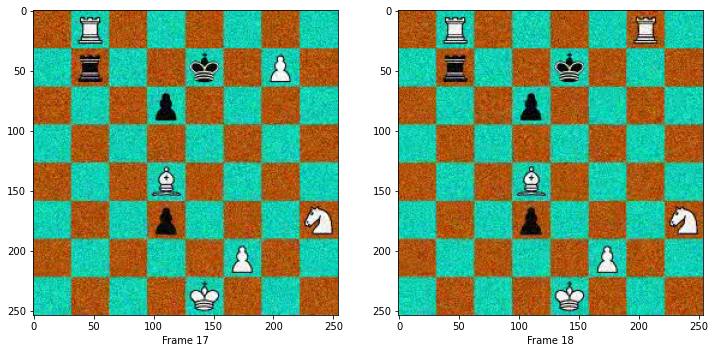

In [ ]:
vid, label, video_id, num_frames, img_stack = show_video(video_id=1867, what='train')

print("No of frames = ", num_frames)
fig = plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(img_stack[17])
plt.xlabel('Frame 17')
plt.subplot(122)
plt.imshow(img_stack[18])
_ = plt.xlabel('Frame 18')

Example 2: Referring to frames 7 and 8 below, the passed pawn at move 3 is a white pawn that transitions upon advancement into a white queen ('Q'), incorrectly labeled as a black queen ('q') in the true moves. 

In [ ]:
true, pred = predict_moves2(video_id=244, what='val', to_print=True)

Pred moves:  f7d8 c7b6 e7e8Q b6a7 d8e6 a7a6 e8d7 a6a5 d2d1
True moves:  f7d8 c7b6 e7e8q b6a7 d8e6 a7a6 e8d7 a6a5 d2d1


No of frames =  31


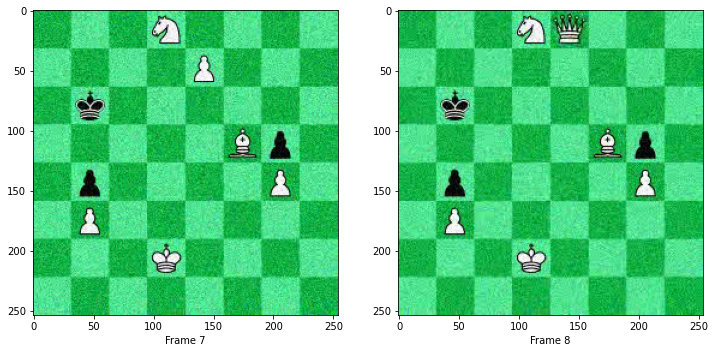

In [ ]:
vid, label, video_id, num_frames, img_stack = show_video(video_id=244, what='val')

print("No of frames = ", num_frames)
fig = plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(img_stack[7])
plt.xlabel('Frame 7')
plt.subplot(122)
plt.imshow(img_stack[8])
_ = plt.xlabel('Frame 8')

### Examples of files for which the non-ML solution missed a move but the ML solution produces the correct sequences of moves

Example 1: 

In [ ]:
true, pred = predict_moves(video_id=670, what='val', to_print=True)

Pred moves:  c6c5 b6d6 b8a6 a1d1 d6f8 f7e6 f8c5
True moves:  c6c5 b6d6 b8a6 a1d1 f8e8 d6f8 f7e6 f8c5


In [ ]:
true, pred = predict_moves2(video_id=670, what='val', to_print=True)

Pred moves:  c6c5 b6d6 b8a6 a1d1 f8e8 d6f8 f7e6 f8c5
True moves:  c6c5 b6d6 b8a6 a1d1 f8e8 d6f8 f7e6 f8c5


Example 2: 

In [ ]:
true, pred = predict_moves(video_id=822, what='val', to_print=True)

Pred moves:  g7f8 e6d5 c1b2 g3e2 g1f2 d5c6
True moves:  g7f8 e5e2 e6d5 c1b2 g3e2 g1f2 d5c6


In [ ]:
true, pred = predict_moves2(video_id=822, what='val', to_print=True)

Pred moves:  g7f8 e5e2 e6d5 c1b2 g3e2 g1f2 d5c6
True moves:  g7f8 e5e2 e6d5 c1b2 g3e2 g1f2 d5c6


### An example of a file for which the non-ML solution missed multiple moves but the ML solution produces the correct sequence of moves

In [ ]:
true, pred = predict_moves(video_id=2794, what='train', to_print=True)

Pred moves:  f4f2 f2c3 c3f4 f8e3 e3g5 f4b8 d6e4 f2e1 b8a5 e1e1*
True moves:  g4h6 d7h3 d6e4 h3c8 g3g2


In [ ]:
true, pred = predict_moves2(video_id=2794, what='train', to_print=True)

Pred moves:  g4h6 d7h3 d6e4 h3c8 g3g2
True moves:  g4h6 d7h3 d6e4 h3c8 g3g2
